## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that we get some practice working with the difficulties of these. 

For this project, I will be performing an A/B test on an e-commerce website.  The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [4]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
df.drop_duplicates('user_id').shape[0]

290584

In [7]:
df.drop_duplicates('user_id')['converted'].mean()

0.11956955647936569

e. The number of times the `new_page` and `treatment` don't line up.

In [8]:
a = df.query('group == "treatment" &  landing_page != "new_page" ').shape[0]
b = df.query('group != "treatment" &  landing_page == "new_page" ').shape[0]
a+b

3893

f. Do any of the rows have missing values?

In [9]:
df[df.isnull().any(axis=1)]

,user_id,timestamp,group,landing_page,converted


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Next we shall find a way to handle these rows.  

a. Now create a new dataset that contains all the `treatment` group landing the new page and the `control` group landing the old page. Store new dataframe in **df2**.

In [10]:
df_t = df.query('group == "treatment" &  landing_page == "new_page" ')
df_c = df.query('group == "control" &  landing_page == "old_page" ')

df2 = df_t.append(df_c)
df2.shape[0]

290585

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [12]:
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

0

`3.` Investigate **df2**.

a. How many unique **user_id**s are in **df2**?

In [13]:
df2.user_id.nunique()

290584

b. Find out all duplicated **user_id**?

In [14]:
df2.user_id.value_counts().index[0]

773192

c. Check the information for the repeat **user_id**? 

In [15]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**.

In [16]:
df2 = df.drop_duplicates('user_id')
df2.shape


(290584, 5)

In [17]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


`4.` Recheck probability.

a. The probability of an individual converting regardless of the page they receive?

In [18]:
df2['converted'].mean()

0.11956955647936569

b. The probability of an individual in the `control` group converting.

In [19]:
p_c = df2[df2['group'] == 'control']['converted'].mean()
p_c

0.12029717968491792

c. The probability of an individual in the `treatment` group converting.

In [20]:
p_t = df2[df2['group'] == 'treatment']['converted'].mean()
p_t

0.11884253398646046

d. The probability that an individual received the new page.

In [21]:
df2[df2['landing_page'] == 'new_page'].shape[0]/df2.shape[0]

0.5000963576797071

**Remark.**

Even through the probablity of the individuals in 'treatment' group converted is lower than the probablity of the individuals in 'control' group converted, it is not of statistically significant. Therefore, this is not an evidence that old_page leads to more conversions.


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` Let **$p_{old}$** and **$p_{new}$** stand for the converted rates for the old and new pages.

**Set null hypothesis and alternative hypothesis.**

$H_0$ : $  p_{new}- p_{old} = 0$

$H_1$ : $ p_{new} -p_{old} \ne 0$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. What is the **convert rate** for $p_{new}$ under the null? 

In [22]:
df2['converted'].mean()

0.11956955647936569

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [23]:
df2['converted'].mean()

0.11956955647936569

c. What is $n_{new}$?

In [24]:
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]
n_new

145320

d. What is $n_{old}$?

In [25]:
n_old = df2[df2['landing_page'] == 'old_page'].shape[0]
n_old

145264

In [26]:
n_new+n_old == df2.shape[0] # double check

True

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
p_null = df2['converted'].mean()
new_page_converted = np.random.choice([0,1],size=n_new,replace=True,p=[1-p_null,p_null])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
old_page_converted = np.random.choice([0,1],size=n_old,replace=True,p=[1-p_null,p_null])

g. Find $p_{new}$ - $p_{old}$ for our simulated values from part (e) and (f).

In [29]:
p_diff = new_page_converted.mean() - old_page_converted.mean()
p_diff

-0.0011822657720149121

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one we calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [ ]:
p_diffs=[]
for _ in range(10000):
    new_page_converted = np.random.choice([0,1],size=n_new,replace=True,p=[1-p_null,p_null])
    old_page_converted = np.random.choice([0,1],size=n_old,replace=True,p=[1-p_null,p_null])
    p_diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(p_diff)
    
    

i. Plot a histogram of the **p_diffs**.

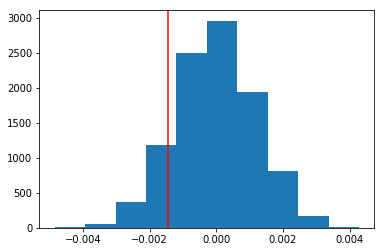

In [32]:
obs = p_t - p_c # the actual difference observed in df2
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);
plt.axvline(x = obs, color = 'r');

In [33]:
(p_diffs.mean(),p_diffs.std()) #the distribution mean and standard deviation. 

(-1.3918369817833264e-05, 0.0012019622840318258)

j. The proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**.

In [34]:
(p_diffs > obs).mean() # p-value

0.88690000000000002

In [35]:
ratio = (obs-p_diffs.mean() )/np.std(p_diffs) # z-score in the distribution of p_diffs
ratio

-1.1986460372174887

**Remark.**

This value obtained above is called p value. Since p > 0.05, it fails to reject the null hypothesis. Therefore, in theis hypothesis test, the null is true there is no difference between the new and old pages.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. In the following, let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [36]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" & converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" & converted == 1').shape[0]
n_old = df2[df2['landing_page'] == 'old_page'].shape[0]
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]

[n_old,n_new],[convert_old,convert_new]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


([145264, 145320], [17489, 17256])

m. Now use `stats.proportions_ztest` to compute our test statistic and p-value.

In [37]:
import statsmodels.api as sm
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old], [n_new,n_old],
                                        alternative = 'larger')
# alterbative = 'larger' means that the alternative hypothesis is p_new - p_old > 0
(z_score, p_value)


(-1.3704617576931086, 0.9147285973840954)

In [38]:
from scipy.stats import norm

norm.cdf(z_score)
# Tells us how significant our z-score is


0.085271402615904601

In [39]:
norm.ppf(1-(0.05/2))
# Tells us what our critical value at 95% confidence is

1.959963984540054

**Remark**

In the above z-test, our null hypothesis is $p_{new}-p_{old} \le 0$ and our alternative hypothesis is $p_{new}-p_{old} > 0.$ Set obs=convert_new/n_new - convert_old/n_old.

By the central limite theorem, we assume that the distribution of $p_{new}-p_{old}$ under the null hypothesis can be approximated by a normal distribution $\mathcal{N}(0,\delta).$ The z-score means how many standard deviations the obs away from the normal distribution mean $0$. The p-value means the probability that we falsely reject the null hypothesis.

Since the z-score of -1.3704617576931086 does not exceed the confidence level $[-1.96,1.96]$ and p-value is really high, we fail to reject the null hypothesis.

The results in part $j$ and $k$ provid a high $p$-value which means that we fail to reject our hull hypothesis. And the value of obs divids the standard deviation of p_diffs is -0.803 which is in the confidence level $[-1.96,1.96].$ These results agree with our findings in part n using z-test.


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, we shall use logistic regression in this case?

b. The goal is to use **statsmodels** to fit the regression model we specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [40]:
df2['intercept'] = 1
df2[['ab_page_c','ab_page']] = pd.get_dummies(df2['group'])
df2.drop('ab_page_c',axis =1,inplace =True)
df2.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import logistic regression model.  Instantiate the model, and fit the model using the two columns we created in part **b.** to predict whether or not an individual converts.

In [41]:
model = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366064
         Iterations 6


d. Provide the summary of our model below.

In [42]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 20 Aug 2018   Pseudo R-squ.:               6.864e-06
Time:                        14:23:28   Log-Likelihood:            -1.0637e+05
converged:                       True   LL-Null:                   -1.0637e+05
                                        LLR p-value:                    0.2269
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9896      0.008   -246.659      0.000      -2.005      -1.974
ab_page       -0.0138      0.011     -1.208      0.227      -0.036       0.009
==============================================================================
"""

In [43]:
np.exp(results.params)

intercept    0.136748
ab_page      0.986277
dtype: float64

**Remark.**

* The p-value associated with ab_page is 0.227. This p-value is under the null hypothesis that the coefficient of ab_page is not zero. While the p-value in Part II is under the null hypothesis that converssion rate of new page is not better than the old page. Therefore, the p-values are different.<br> </br>

* It is possible that the only factor does not fit well our model. Adding new factors into our regression model may make the data fits our model better. However, the new factor we are adding may lead multicollinearity, which will reduce the precision of our prediction.


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. We will see that if country had an impact on conversion.

In [44]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new[['CA','UK','US']] = pd.get_dummies(df_new['country'])

In [45]:
model = sm.Logit(df_new['converted'],df_new[['intercept','UK','US']])
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366062
         Iterations 6


In [46]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 20 Aug 2018   Pseudo R-squ.:               1.261e-05
Time:                        14:23:29   Log-Likelihood:            -1.0637e+05
converged:                       True   LL-Null:                   -1.0637e+05
                                        LLR p-value:                    0.2614
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0335      0.026    -78.330      0.000      -2.084      -1.983
UK             0.0460      0.028      1.623      0.105      -0.010       0.102
US             0.0363      0.027      1.353      0.176      -0.016       0.089
==============================================================================
"""

In [47]:
np.exp(results.params)

intercept    0.130879
UK           1.047094
US           1.037001
dtype: float64

**Conclusion**

The converssion rate in UK is 1.05 times as likely than in CA holding all all esle constant. 

The converssion rate in US is 1.04 times as likely than in CA holding all all esle constant. 

However, since the p-values associated with the cofficients of UK and US are greather than 0.05, the changes in countries are not associated with changes in converssion rates.  

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create an additional columns `ab_page*country`, and fit the new model.  

In [48]:
df_new['treatment_US'] = df_new['ab_page']*df_new['US']
df_new['treatment_UK'] = df_new['ab_page']*df_new['UK']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,treatment_US,treatment_UK
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1


In [49]:
model = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','UK','US','treatment_US','treatment_UK']])
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366056
         Iterations 6


In [50]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 20 Aug 2018   Pseudo R-squ.:               2.826e-05
Time:                        14:23:30   Log-Likelihood:            -1.0637e+05
converged:                       True   LL-Null:                   -1.0637e+05
                                        LLR p-value:                    0.3049
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -2.0026      0.036    -54.964      0.000      -2.074      -1.931
ab_page         -0.0620      0.052     -1.194      0.232      -0.164       0.040
UK               0.0111      0.040      0.279      0.780      -0.067       0.089
US               0.0145      0.038      0.386      0.700      -0.059       0.088
treatment_US     0.0438      0.054      0.815      0.415      -0.061       0.149
treatment_UK     0.0700      0.057      1.234      0.217      -0.041       0.181
================================================================================
"""

In [51]:
np.exp(results.params)

intercept       0.134986
ab_page         0.939870
UK              1.011197
US              1.014639
treatment_US    1.044753
treatment_UK    1.072511
dtype: float64

**Conclusion**

Since the p-values associated with the cofficients of all the factors are greather than 0.05, the changes in the countries, pages and their interactions are not associated with changes in converssion rates.  

In [53]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0